In [47]:
%load_ext autoreload 
%autoreload 2
import os, sys
import pandas as pd 
import numpy as np 
sys.path.append('../')
from util_preprocess.fuctions import *
from matplotlib import pyplot as plt
import requests, re
import datetime
from get_currency_data import get_currency_table
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
temp_df = get_currency_table()


### Read data 

In [45]:
df = pd.read_hdf('../currency_data/currency.h5')

df['USD_NTD']  = df['美元／新台幣']
df['RMD_NTD']  = df['人民幣／新台幣']
df['UD_USD'] = df['歐元／美元']
df['USD_JPD'] = df['美元／日幣']
df['USD_RMB'] = df['美元／人民幣']
df['END_USD'] = df["英鎊／美元"]
df['Date']    = df['日期']
del df['美元／新台幣']
del df['人民幣／新台幣']
del df['歐元／美元']
del df['美元／日幣']
del df['美元／人民幣']
del  df["英鎊／美元"]
del  df['日期']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

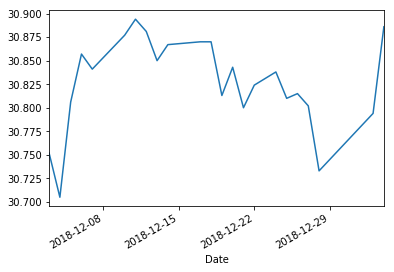

In [46]:
df = df.sort_index()
df['USD_NTD_Trend'] = trend(list(df['USD_NTD']))
df['USD_NTD_Label'] = trend_2(list(df['USD_NTD']))

df['USD_NTD'].astype(float).plot()


In [350]:
#df['USD_NTD'].plot()
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
df.head()
col = ["USD_NTD", "RMD_NTD","UD_USD","USD_JPD","USD_RMB","USD_NTD_Trend"]


train_df = df.copy()

In [351]:
# previous_Ndays_price([1, 2, 4, 5, 6, 7, 8], 3)
for N in [ 5, 9]:
    for c in col:
        train_df[c+'_pre_d{}'.format(N)] = previous_Ndays_price_delta( list( train_df[c]), N)
        train_df[c+'_pre_{}'.format(N)] = previous_Ndays_price( list( train_df[c]), N)
        train_df[c+'_pre_dp[{}'.format(N)] = previous_Ndays_price_delta_percent( list( train_df[c]), N)
        


In [256]:
# alone time convolution 


In [352]:
col = [i for i in train_df.columns if i not in ['USD_NTD_Label', 
                                                '紐幣／美元', 
                                                '澳幣／美元',
                                                '美元／港幣']]
display(train_df[col][9:].head())
X = train_df[col].values[9:-1]
y = train_df["USD_NTD_Label"].values[9+1:]
y_5days = up_within_Ndays(y)
y_3days = up_within_Ndays(y, 3)
y_2days = up_within_Ndays(y, 2)


,美元／南非幣,USD_NTD,RMD_NTD,UD_USD,USD_JPD,USD_RMB,END_USD,USD_NTD_Trend,USD_NTD_pre_d5,USD_NTD_pre_5,...,UD_USD_pre_dp[9,USD_JPD_pre_d9,USD_JPD_pre_9,USD_JPD_pre_dp[9,USD_RMB_pre_d9,USD_RMB_pre_9,USD_RMB_pre_dp[9,USD_NTD_Trend_pre_d9,USD_NTD_Trend_pre_9,USD_NTD_Trend_pre_dp[9
日期,,,,,,,,,,,,,,,,,,,,,
2016-01-15,16.56000,33.802,5.106570,1.08835,117.610,6.6193,1.4393,5,-0.301,33.501,...,0.003951,1.245,118.855,0.010586,-0.0030,6.6163,-0.000453,-5.0,0.0,-1.000000
2016-01-18,16.74385,33.818,5.127756,1.08835,117.245,6.5951,1.4297,6,-0.167,33.651,...,-0.006294,2.010,119.255,0.017144,0.0461,6.6412,0.006990,-5.0,1.0,-0.833333
2016-01-19,16.59670,33.820,5.124305,1.08755,117.945,6.5999,1.4300,7,-0.153,33.667,...,-0.012873,0.690,118.635,0.005850,0.1033,6.7032,0.015652,-5.0,2.0,-0.714286
2016-01-20,16.82140,33.826,5.124064,1.09505,116.725,6.6014,1.4168,8,-0.201,33.625,...,-0.015707,1.370,118.095,0.011737,0.0879,6.6893,0.013315,-5.0,3.0,-0.625000
2016-01-21,16.73580,33.838,5.117591,1.08935,117.065,6.6121,1.4167,9,-0.096,33.742,...,-0.000046,1.200,118.265,0.010251,0.0733,6.6854,0.011086,-7.0,2.0,-0.777778


In [353]:
def kflod_trainer(X, y, model, nsplit=3, feats=col):
    fold = StratifiedKFold(nsplit)
    for train_ind, valid_ind in fold.split(X, y):
        trX, trY = X[train_ind], y[train_ind]
        vaX, vaY = X[valid_ind], y[valid_ind]
        model.fit(trX, trY)
        pre_y = model.predict(vaX)
        loss = classification_report(vaY, pre_y, )
        print('----------------------------------------------------------------')
        print(loss)
        res_df = pd.DataFrame()
        res_df['feats'] = feats
        res_df.index = [round(i, 3) for i in 
                        list(model.feature_importances_)]
        display(res_df.sort_index())
for i in [2, 3, 4]:
    kflod_trainer(X, y_2days, GradientBoostingClassifier(max_depth=2 ), i)
# kflod_trainer(X, y_2days, LogisticRegression(C=0.1 ), 2)

----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.17      0.67      0.27        27
        1.0       0.82      0.32      0.46       127

avg / total       0.71      0.38      0.43       154



,feats
0.000,USD_NTD_Trend_pre_d9
0.000,RMD_NTD
0.000,USD_RMB_pre_d5
0.000,USD_JPD
0.000,USD_RMB
0.000,USD_RMB_pre_9
0.000,USD_JPD_pre_dp[9
0.000,USD_NTD_pre_dp[5
0.000,USD_RMB_pre_dp[5
0.000,USD_NTD_Trend_pre_dp[5


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.18      0.88      0.30        26
        1.0       0.88      0.18      0.30       126

avg / total       0.76      0.30      0.30       152



,feats
0.000,USD_RMB_pre_dp[9
0.000,USD_RMB_pre_d9
0.000,USD_JPD_pre_9
0.000,USD_NTD_Trend_pre_d9
0.000,USD_NTD_Trend_pre_d5
0.000,USD_JPD_pre_5
0.000,USD_NTD_Trend
0.001,UD_USD_pre_d9
0.003,UD_USD_pre_dp[5
0.003,美元／南非幣


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.21      1.00      0.35        18
        1.0       1.00      0.20      0.33        85

avg / total       0.86      0.34      0.34       103



,feats
0.000,USD_NTD_Trend_pre_dp[5
0.000,UD_USD
0.000,USD_JPD
0.000,USD_RMB
0.000,USD_NTD_Trend_pre_d9
0.000,UD_USD_pre_d9
0.000,UD_USD_pre_dp[5
0.003,USD_NTD_pre_dp[5
0.004,USD_NTD_Trend_pre_5
0.004,UD_USD_pre_d5


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.07      0.06      0.06        18
        1.0       0.81      0.85      0.83        84

avg / total       0.68      0.71      0.69       102



,feats
0.000,UD_USD_pre_d9
0.000,USD_NTD_Trend_pre_d9
0.000,USD_NTD_Trend_pre_d5
0.000,UD_USD_pre_dp[9
0.000,USD_JPD_pre_dp[5
0.002,USD_RMB
0.002,USD_RMB_pre_dp[9
0.003,USD_NTD_Trend_pre_dp[5
0.004,RMD_NTD_pre_d5
0.005,USD_NTD_pre_9


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.05      0.12      0.07        17
        1.0       0.76      0.57      0.65        84

avg / total       0.64      0.50      0.56       101



,feats
0.000,USD_NTD_Trend_pre_d9
0.000,RMD_NTD_pre_dp[9
0.001,USD_JPD_pre_9
0.001,UD_USD_pre_dp[5
0.003,美元／南非幣
0.003,UD_USD_pre_9
0.003,USD_NTD_Trend_pre_d5
0.005,UD_USD_pre_d9
0.005,USD_JPD_pre_d5
0.006,RMD_NTD


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.07      0.14      0.10        14
        1.0       0.76      0.59      0.67        64

avg / total       0.64      0.51      0.56        78



,feats
0.000,UD_USD_pre_5
0.000,RMD_NTD
0.000,UD_USD
0.000,USD_NTD_Trend_pre_9
0.000,USD_NTD_Trend_pre_d9
0.003,USD_NTD_Trend_pre_dp[9
0.003,USD_NTD_Trend_pre_dp[5
0.005,UD_USD_pre_d9
0.005,USD_RMB
0.005,USD_JPD


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.12      0.08      0.10        13
        1.0       0.82      0.89      0.85        63

avg / total       0.70      0.75      0.73        76



,feats
0.000,UD_USD_pre_d5
0.000,USD_RMB_pre_dp[5
0.000,USD_RMB_pre_d5
0.000,UD_USD_pre_dp[9
0.000,USD_RMB
0.000,USD_JPD_pre_dp[9
0.000,USD_NTD_Trend_pre_d9
0.002,USD_JPD_pre_dp[5
0.002,UD_USD_pre_dp[5
0.002,USD_JPD_pre_d9


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        13
        1.0       0.82      0.95      0.88        63

avg / total       0.68      0.79      0.73        76



,feats
0.000,USD_NTD_Trend_pre_d9
0.000,USD_RMB_pre_9
0.000,UD_USD_pre_dp[9
0.004,USD_NTD_Trend_pre_dp[9
0.004,USD_JPD_pre_dp[5
0.004,UD_USD_pre_5
0.005,USD_NTD_pre_9
0.006,UD_USD_pre_d9
0.006,RMD_NTD_pre_d5
0.006,UD_USD_pre_d5


----------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.27      0.31      0.29        13
        1.0       0.85      0.83      0.84        63

avg / total       0.75      0.74      0.74        76



,feats
0.000,USD_NTD_Trend_pre_dp[9
0.000,USD_NTD_Trend_pre_d9
0.002,USD_JPD_pre_dp[5
0.002,USD_RMB_pre_9
0.003,UD_USD_pre_d9
0.004,USD_NTD_Trend_pre_d5
0.006,USD_JPD_pre_9
0.006,USD_RMB_pre_d5
0.007,USD_RMB_pre_dp[9
0.008,UD_USD_pre_dp[9


In [304]:
set(y_2days)

{1.0}

In [315]:
a = GradientBoostingClassifier()

In [ ]:
class Node(object):
    def __init__(self):
        self.l = None 
        self.r = None
        self.rule = {}
    
class DecisionTree():
    def __init__(self):
        pass
    def greedy_construct(self):
        pass
    

In [ ]:
'../sct/data/'